In [ ]:
# Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pycocotools.coco import COCO
import skimage.io as io
import matplotlib.patches as patches
import random
import os
import json
import time
import numpy as np
from PIL import Image, ImageDraw
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt
import torchvision.transforms as T

In [ ]:
# extract the zip folder
%%capture
!unzip "/content/drive/Othercomputers/My Mac/Image Segmentation/dataset/RM_Segmentation_Assignment_dataset.zip" -d "/content/drive/Othercomputers/My Mac/Image Segmentation/dataset/images"

In [ ]:
# load the training images
train_data_path = "/content/drive/Othercomputers/My Mac/Image Segmentation/dataset/images/train-300/data"
train_annotation = "/content/drive/Othercomputers/My Mac/Image Segmentation/dataset/images/train-300/labels.json"
val_data_path = "/content/drive/Othercomputers/My Mac/Image Segmentation/dataset/images/validation-300/data"
val_annotation = "/content/drive/Othercomputers/My Mac/Image Segmentation/dataset/images/validation-300/labels.json"
coco = COCO(train_annotation)

loading annotations into memory...
Done (t=2.00s)
creating index...
index created!


In [ ]:
# Get the categories IDs
category_IDs = coco.getCatIds()
categories = coco.loadCats(category_IDs)
print(categories)

[{'id': 0, 'name': 'airplane', 'supercategory': 'vehicle'}, {'id': 1, 'name': 'backpack', 'supercategory': 'accessory'}, {'id': 2, 'name': 'banana', 'supercategory': 'food'}, {'id': 3, 'name': 'baseball bat', 'supercategory': 'sports'}, {'id': 4, 'name': 'baseball glove', 'supercategory': 'sports'}, {'id': 5, 'name': 'bear', 'supercategory': 'animal'}, {'id': 6, 'name': 'bench', 'supercategory': 'outdoor'}, {'id': 7, 'name': 'bicycle', 'supercategory': 'vehicle'}, {'id': 8, 'name': 'bird', 'supercategory': 'animal'}, {'id': 9, 'name': 'boat', 'supercategory': 'vehicle'}, {'id': 10, 'name': 'book', 'supercategory': 'indoor'}, {'id': 11, 'name': 'bottle', 'supercategory': 'kitchen'}, {'id': 12, 'name': 'bowl', 'supercategory': 'kitchen'}, {'id': 13, 'name': 'broccoli', 'supercategory': 'food'}, {'id': 14, 'name': 'bus', 'supercategory': 'vehicle'}, {'id': 15, 'name': 'cake', 'supercategory': 'food'}, {'id': 16, 'name': 'car', 'supercategory': 'vehicle'}, {'id': 17, 'name': 'carrot', 'sup

In [ ]:
names_cats = [cats["name"] for cats in categories]
print(len(names_cats), "COCO categories:", " ".join(names_cats))

names_scats = set([cats["supercategory"] for cats in categories])
print(len(names_scats), "COCO supercategories:", " ".join(names_scats))

63 COCO categories: airplane backpack banana baseball bat baseball glove bear bench bicycle bird boat book bottle bowl broccoli bus cake car carrot cat cell phone chair clock cow cup dining table dog donut elephant fire hydrant fork frisbee giraffe handbag horse hot dog kite knife laptop motorcycle oven parking meter person pizza potted plant refrigerator remote sandwich scissors skateboard skis spoon sports ball stop sign suitcase surfboard tennis racket tie traffic light train truck umbrella vase wine glass
12 COCO supercategories: appliance person furniture accessory kitchen animal outdoor vehicle food indoor sports electronic


In [ ]:
# Function to get the category name
def get_category_name(class_ID, categories):
    for i in range(len(categories)):
        if categories[i]["id"] == class_ID:
            return categories[i]["name"]
    return "None"

In [ ]:
# Print category name
category_name_15 = get_category_name(15, categories)
print(f"The category name is {category_name_15}.")

The category name is cake.


In [ ]:
# Print the category and number of images in specific classes.
filter_classes = ["cat","Cake","Person","dog"]

for filter_class in filter_classes:
    category_IDs = coco.getCatIds(catNms=filter_class)
    image_IDs = coco.getImgIds(catIds=category_IDs)
    print(f"Number of images containing {filter_class}: {len(image_IDs)}.")
    print(f"IDs of images containing specified category(ies): {image_IDs}.")

Number of images containing cat: 4.
IDs of images containing specified category(ies): [299, 132, 268, 294].
Number of images containing Cake: 300.
IDs of images containing specified category(ies): [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 

{'id': 32, 'file_name': '000000002754.jpg', 'height': 480, 'width': 640, 'license': None, 'coco_url': None}


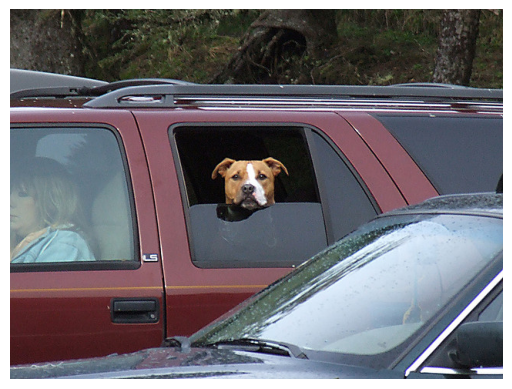

In [ ]:
# Print and example Image
example_image = coco.loadImgs(image_IDs[0])[0]
print(example_image)
image = io.imread(f'{train_data_path}/{example_image["file_name"]}')
plt.axis("off")
plt.imshow(image)
plt.show()

In [ ]:
# Print the annotation IDs
test_image_annotations_ID = coco.getAnnIds(
    imgIds=example_image["id"], catIds=category_IDs, iscrowd=None
)
print(test_image_annotations_ID)


test_image_annotations = coco.loadAnns(test_image_annotations_ID)
print(test_image_annotations)

[353]
[{'id': 353, 'image_id': 32, 'category_id': 25, 'bbox': [252.09, 190.35, 109.71000000000001, 137.54], 'segmentation': [[350.0, 326.5, 251.5, 325.0, 263.5, 289.0, 278.5, 259.0, 281.0, 256.5, 300.5, 258.0, 279.0, 254.5, 277.5, 221.0, 272.0, 215.5, 269.0, 221.5, 261.5, 220.0, 263.5, 207.0, 274.0, 194.5, 286.0, 192.5, 300.0, 195.5, 339.0, 189.5, 357.5, 205.0, 360.0, 214.5, 351.0, 207.5, 348.5, 213.0, 342.5, 216.0, 343.5, 250.0, 330.5, 257.0, 337.0, 255.5, 339.5, 259.0, 341.5, 285.0, 350.0, 326.5], [305.5, 259.0, 301.5, 259.0, 305.5, 259.0]], 'area': 15089.5134, 'iscrowd': 0, 'supercategory': 'animal'}]


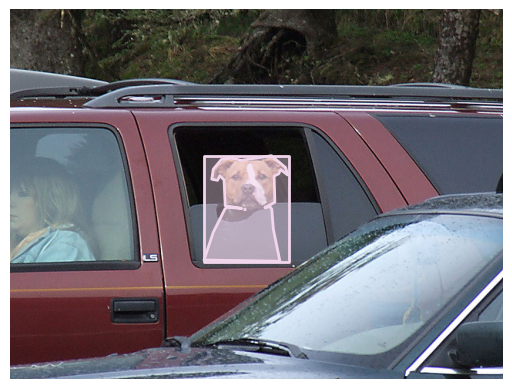

In [ ]:
# Show Image with bounding box
plt.imshow(image)
plt.axis("off")
coco.showAnns(test_image_annotations, draw_bbox=True)

In [ ]:
#  Get images containing combination of the four target classes.

target_classes = ["cake", "cat", "dog", "person"]
target_classes_IDs = coco.getCatIds(catNms=target_classes)
training_images = []

for class_name in target_classes:
    # Get all images containing target class.
    print(class_name)
    training_images_categories = coco.getCatIds(catNms=class_name)
    training_images_IDs = coco.getImgIds(catIds=training_images_categories)
    training_images += coco.loadImgs(training_images_IDs)

print(f"Number of images with target classes including repetitions: {len(training_images)}.")

cake
cat
dog
person
Number of images with target classes including repetitions: 287.


In [ ]:
# Filter out repeated images.

unique_training_images = []

for i in range(len(training_images)):
    if training_images[i] not in unique_training_images:
        unique_training_images.append(training_images[i])

# Shuffle the training data.
random.seed(0)
random.shuffle(unique_training_images)

print(
    f"Number of unique images in training data containing the target classes: {len(unique_training_images)}"
)

Number of unique images in training data containing the target classes: 276


{'id': 66, 'file_name': '000000004736.jpg', 'height': 426, 'width': 640, 'license': None, 'coco_url': None}


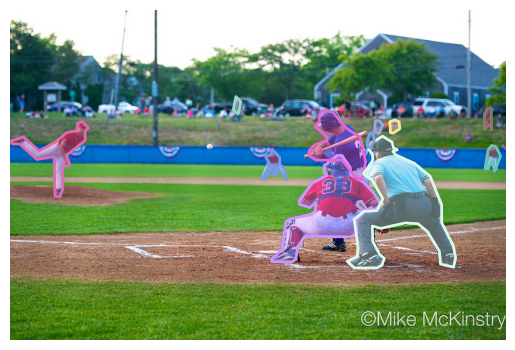

In [ ]:
# Show Annotations

training_image = unique_training_images[5]
print(training_image)

image = io.imread(f'{train_data_path}/{training_image["file_name"]}')
plt.axis("off")
plt.imshow(image)

training_image_annotations_ID = coco.getAnnIds(
    imgIds=training_image["id"], catIds=target_classes_IDs, iscrowd=None
)
training_image_annotations = coco.loadAnns(training_image_annotations_ID)
coco.showAnns(training_image_annotations, draw_bbox=False)

plt.show()

In [ ]:
mask_example = coco.annToMask(training_image_annotations[0])
print(type(mask_example))
print(mask_example)
print(mask_example.shape)
print(np.max(mask_example))
print(np.min(mask_example))

<class 'numpy.ndarray'>
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
(426, 640)
1
0


Unique pixel values in the mask: [0. 3.]


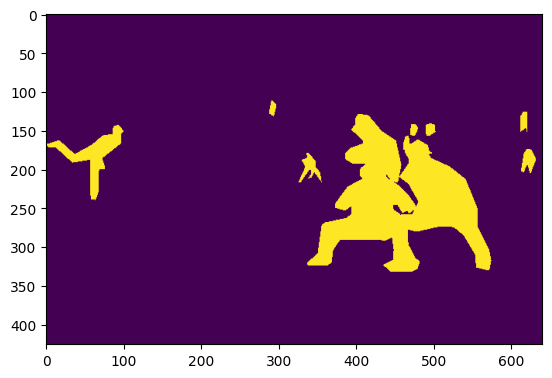

In [ ]:
mask = np.zeros((training_image["height"], training_image["width"]))

for i in range(len(training_image_annotations)):
    # Get object category name.
    object_category = get_category_name(
        training_image_annotations[i]["category_id"], categories
    )
    # Assign pixel value based on location in target_classes list.
    pixel_value = target_classes.index(object_category) + 1
    # Assign pixel value to mask based on annToMask output.
    mask = np.maximum(coco.annToMask(training_image_annotations[i]) * 3, mask)

print(f"Unique pixel values in the mask: {np.unique(mask)}")
plt.imshow(mask)
plt.show()

### UNet Model